In [1]:
# !git clone https://github.com/tordjx/ummt.git
# import os 
# os.chdir("ummt/Core model files")
# os.getcwd()
!pip install matplotlib --quiet
!pip install livelossplot --quiet
!pip install opencv-python-headless --quiet
!pip install nltk --quiet
!pip install torchtext --quiet
!pip install torchmetrics --quiet
#mc cp s3/tordjx ummt/Core*model*files --recursive
# watch -n 0.5 nvidia-smi
import nltk
nltk.download('wordnet')
image_bool = True
load_model = True


[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 
from greedy_beam_search import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size,True)
tokenized_val_fr,tokenized_val_en, _,_ = get_train_data_nouveau(batch_size,False)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head =8
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 512
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 128
prefix = ""

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],False,prefix).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],False,prefix).to(device)

if load_model : 
    model_en.load_state_dict(torch.load("tordjx/"+prefix+"_en"))
    model_fr.load_state_dict(torch.load("tordjx/"+prefix+"_fr"))
else : 
    with open(prefix+"logs.txt",'w') as logs :
        logs.write("")
        logs.close()

if image_bool :
    train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
    val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
    train_features = torch.from_numpy(train_features)
    val_features = torch.from_numpy(val_features)
    train_data_fr = [tokenized_fr, train_features]
    train_data_en = [tokenized_en, train_features]
    val_data_fr = [tokenized_val_fr, val_features]
    val_data_en = [tokenized_val_en, val_features]
def save_model(model_en,model_fr,prefix):
    torch.save(model_fr.state_dict(), "tordjx/"+prefix+"_fr")
    torch.save(model_en.state_dict(), "tordjx/"+prefix+"_en")
    import os
    import s3fs
    !pip install pandas
    import pandas
    # Create filesystem object
    S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
    fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
    fs.upload("tordjx/"+prefix+"_fr","tordjx/"+prefix+"_fr")
    fs.upload("tordjx/"+prefix+"_en","tordjx/"+prefix+"_en")

In [ ]:
teacher_forcing = True
bools = [False,True]
for image_bool in bools : 
    if image_bool :
        mixed_train(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,45,batch_size, True,1/2)
    else :
        mixed_train(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,45,batch_size, False,1/2)
    save_dataframe_eval(model_fr,model_en,val_data_en,val_data_fr,inv_map_en,inv_map_fr,image_bool,batch_size,48,"beam")

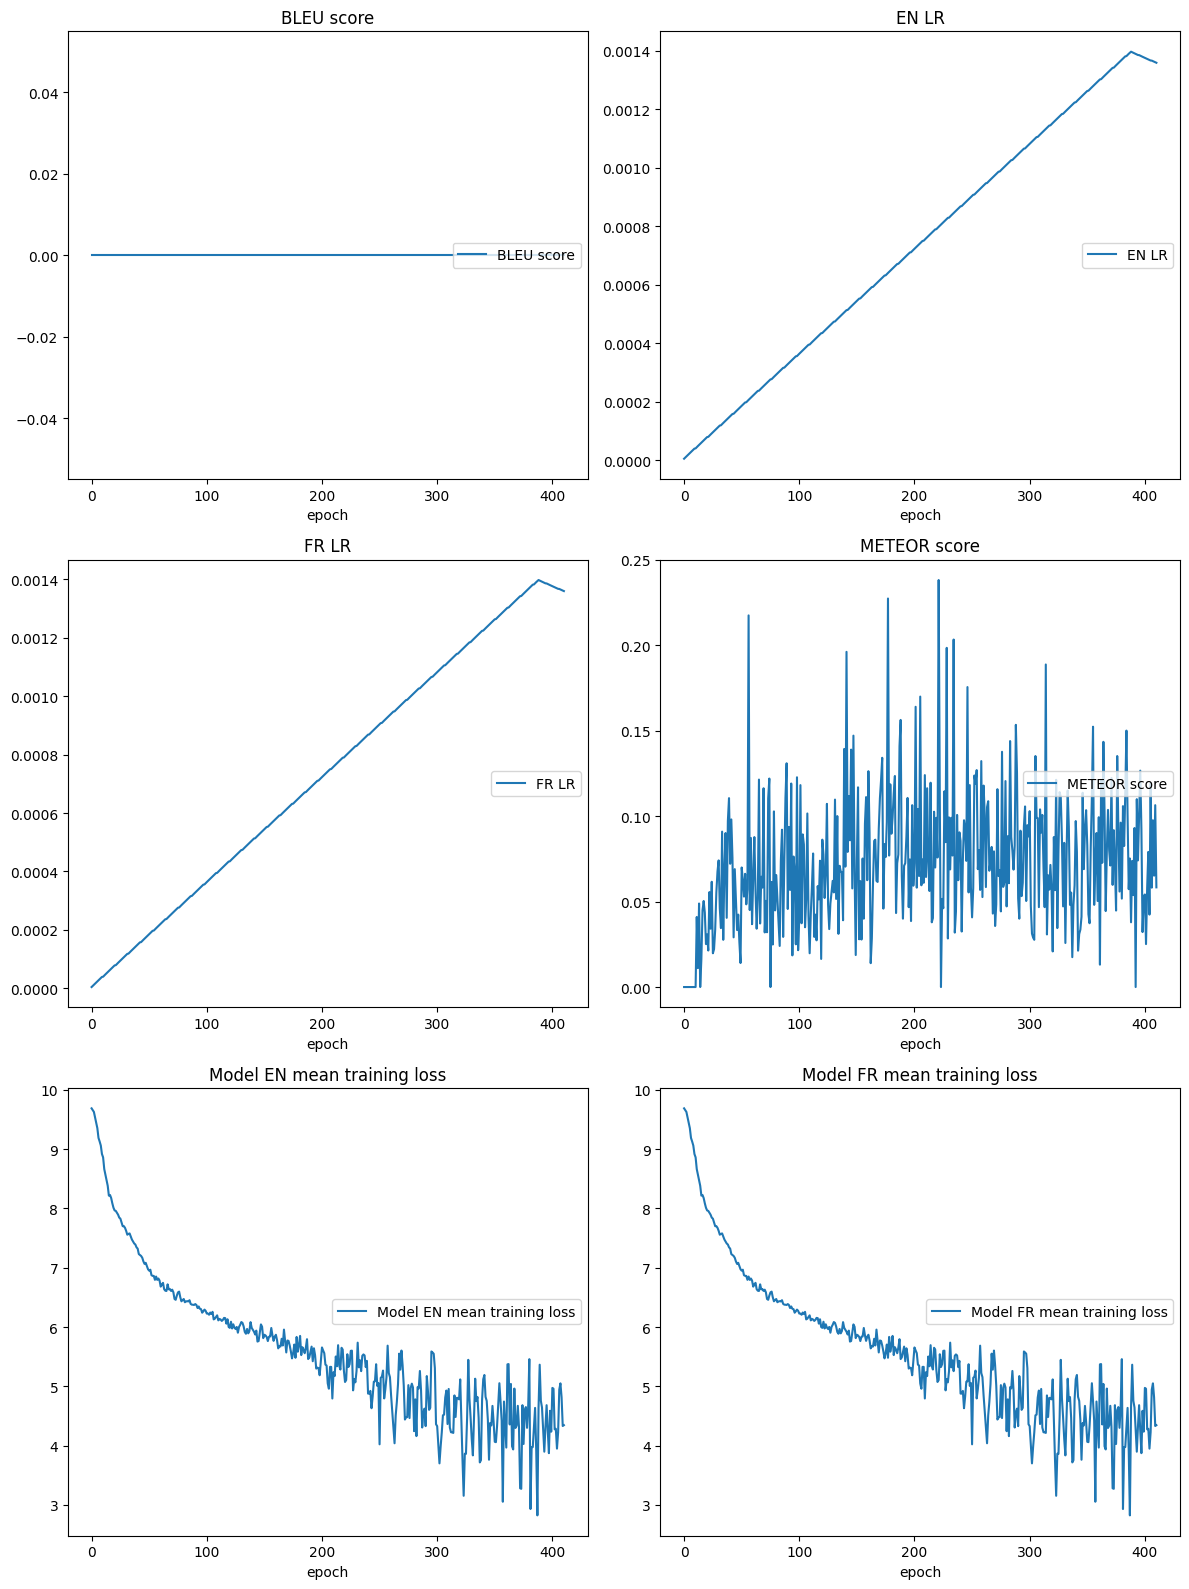

BLEU score
	BLEU score       	 (min:    0.000, max:    0.000, cur:    0.000)
EN LR
	EN LR            	 (min:    0.000, max:    0.001, cur:    0.001)
FR LR
	FR LR            	 (min:    0.000, max:    0.001, cur:    0.001)
METEOR score
	METEOR score     	 (min:    0.000, max:    0.238, cur:    0.058)
Model EN mean training loss
	Model EN mean training loss 	 (min:    2.824, max:    9.686, cur:    4.345)
Model FR mean training loss
	Model FR mean training loss 	 (min:    2.824, max:    9.686, cur:    4.345)


In [ ]:
#On va entrainer 4 modeles : avec/sans images, avec/sans teacher forcing
teacher_forcing = True
bools = [True]
for image_bool in bools : 
    prefix = str(image_bool)+str(teacher_forcing)
    model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
    model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
    with open(prefix+"logs.txt",'w') as logs :
        logs.write("")
        logs.close()
    if image_bool :
        mixed_train(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,45,batch_size, True,1/2)
    else :
        mixed_train(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,45,batch_size, False,1/2)
    torch.save(model_fr.state_dict(), "tordjx/"+prefix+"_fr")
    torch.save(model_en.state_dict(), "tordjx/"+prefix+"_en")
    pd.DataFrame(model_en.loss_list).to_csv("tordjx/"+prefix+"loss_en.csv")
    pd.DataFrame(model_fr.loss_list).to_csv("tordjx/"+prefix+"loss_fr.csv")
    

In [3]:

from torchvision import models, transforms
from PIL import Image

import os

def open_image(path):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image
from torchvision.models.feature_extraction import create_feature_extractor
with open('Images ummt/captions.txt','r') as file : 
    lines = file.readlines()
    file.close()

lines = [line[:-1].split(',') for line in  lines]
images= [line[0] for line in lines]
captions = [line[1][1:] for line in lines]
folder =["blurred","contrast","cropped","negative","noisy","raw","rotated90","rotated180","rotated270","wrong"]
text=[]
titres = []
features=[]
paths = []

for name in folder :
    text+=captions
    titres+=[name+"_"+ image for image in images]
    for image in images: 
        paths.append('Images ummt/'+name+'/'+image)
        # if features == []:
        #     features = get_resnet_features_from_image(open_image('Images ummt/'+name+'/'+image).unsqueeze(0))
        # else : 
        #     features = torch.cat((features,get_resnet_features_from_image(open_image('Images ummt/'+name+'/'+image).unsqueeze(0))))
# print(features.shape)
features = torch.from_numpy(np.load('all-resnet50-res4frelu.npy')).to(device).view(160,1024,196).transpose(-1,-2)
# features = features.to(device)
# features = features.view(-1,1024,196).transpose(-1,-2)
# torch.save(features,"features_test")
text = [["DEBUT_DE_PHRASE"]+ligne.strip().split(" ")+["FIN_DE_PHRASE"] for ligne in text ]
longueur_max = 64
text = [[phrase[i] if i < len(phrase) else "TOKEN_VIDE" for i in range (longueur_max)] for phrase in text]
text = torch.tensor([[vocab_en[mot] for mot in phrase] for phrase in text]).to(device = device, dtype = torch.long)
text = torch.cat((text, torch.zeros(batch_size-text.shape[0],text.shape[1]).to(device = device, dtype = torch.long)))
features = torch.cat((features,torch.zeros(batch_size-features.shape[0],features.shape[1],features.shape[2]).to(device = device, dtype = torch.float)))
def plot_attention_text(phrase, trad,attention_text,titre):
    plt.clf()
    fig, ax = plt.subplots(1,1)
    attention_text = attention_text[:len(phrase)][:len(phrase)]
    attention_text = attention_text.cpu().detach().numpy()
    plt.imshow(attention_text,cmap = "inferno")
    ax.set_xticks([i for i in range(len(trad))])
    ax.set_xticklabels(trad,rotation = 90)
    ax.set_yticks([i for i in range(len(phrase))])
    ax.set_yticklabels(phrase)
    plt.colorbar()
    plt.savefig("Graphs attention/"+titre+"attention_text.png")
    plt.savefig("Graphs attention/Attention texte/"+titre+"attention_text.png")
    plt.close()
def plot_attention_on_image(path,attention,titre,phrase):
    for i in range (len(phrase)):
        plt.clf()
        mot = phrase[i]
        attention_mot= attention[i]
        attention_mot = repeater(attention_mot).cpu().detach().numpy() 
        image= open_image(path)
        image = image.cpu().detach().numpy()
        image = image.transpose(1,2,0)
        plt.imshow(image)
        plt.imshow(attention_mot,alpha = 0.5,cmap = "inferno")
        plt.colorbar()
        plt.title(mot)
        plt.savefig("Graphs attention/"+str(i)+"_"+titre +mot+"attention_image.png")
        plt.close()
from PIL import Image
import os
def open_image(path):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image
def graphiques_attention(model_fr,model_en,batched_data_en,inv_map_en,inv_map_fr,batch_size,images,titres,paths) :
    model_fr.eval()
    model_en.eval()
    src,features = batched_data_en
    src,features = src.to(device),features.to(device)
    traduction,attention_e,attention_i= CCF_greedy(model_en,model_fr,src,features,True,True)
    traduction = torch.argmax(traduction ,dim = 2)
    for i in range(len(titres)):
        phrase  = cut_list_at_value([inv_map_en[src[i][j].item()] for j in range(src.shape[1])] ,"FIN_DE_PHRASE")
        phrase = [x for x in phrase if x not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]]
        attention_i = attention_i.view(256,-1,14,14)
        trad = cut_list_at_value([inv_map_fr[x.item()] for x in traduction[i]],'FIN_DE_PHRASE')
        trad = [x for x in trad if x not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]]
        plot_attention_text(phrase,trad,attention_e[i],titres[i])
        plot_attention_on_image(paths[i],attention_i[i],titres[i],phrase)
prefix = 'TrueTrue'
model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],False,prefix).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],False,prefix).to(device)
model_en.load_state_dict(torch.load("tordjx/"+prefix+"_en"))
model_fr.load_state_dict(torch.load("tordjx/"+prefix+"_fr"))

graphiques_attention(model_fr,model_en,[text,features],inv_map_en,inv_map_fr,batch_size,images,titres,paths)

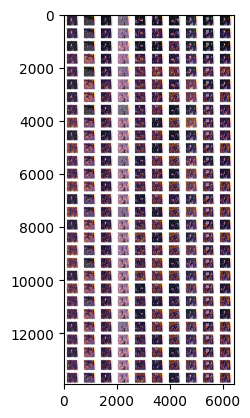

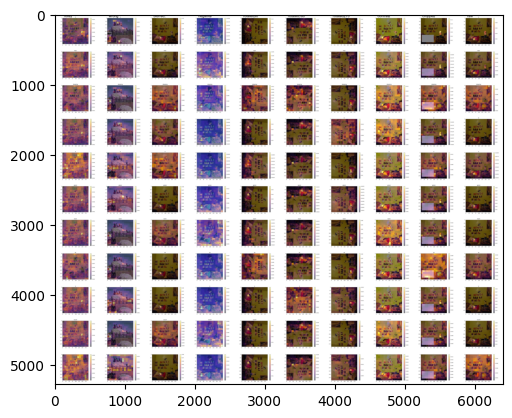

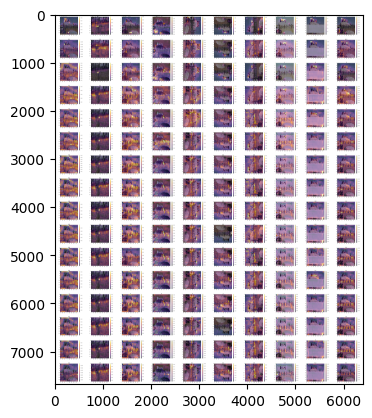

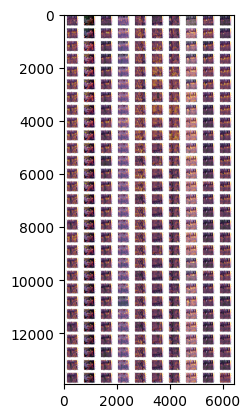

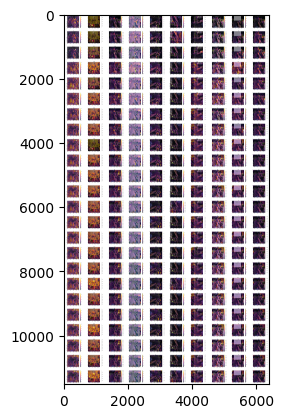

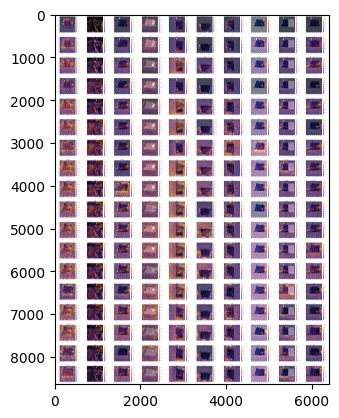

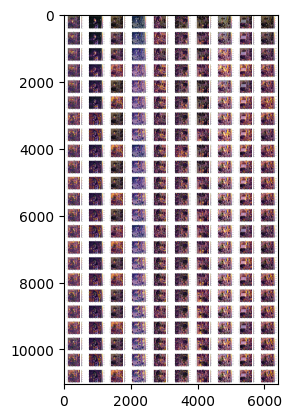

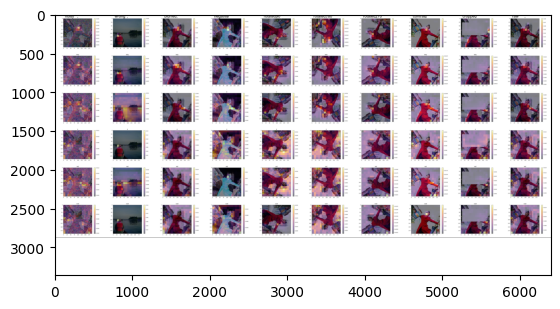

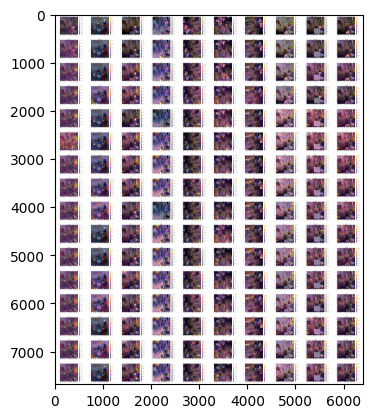

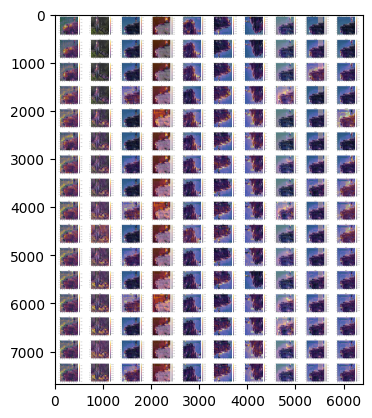

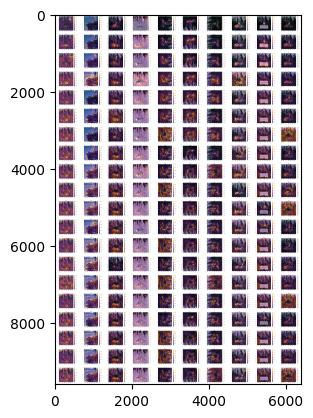

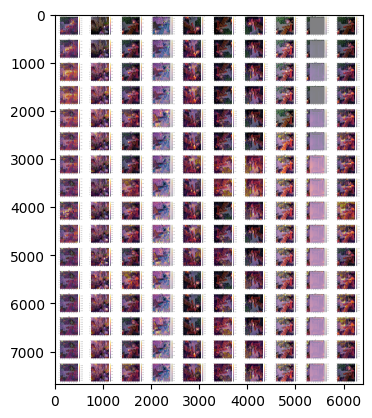

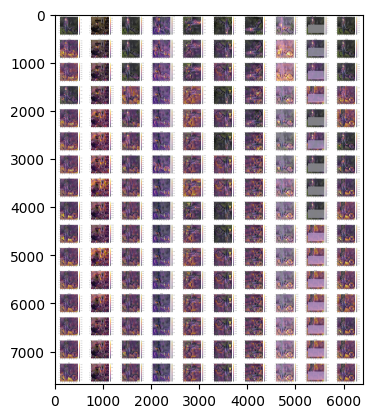

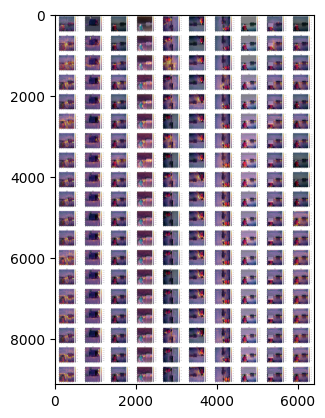

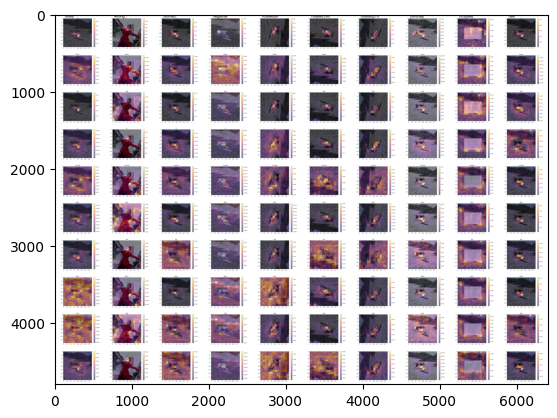

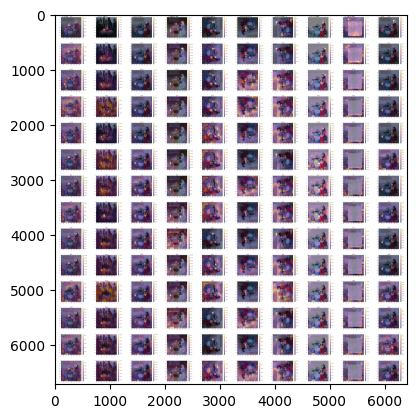

In [9]:

import os
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
transformations = ['noisy','wrong','blurred','negative','rotated90','rotated180','rotated270','contrast','cropped','raw']
dico= {}
photos = []
from PIL import Image

def open_image(path):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image

def save_image(image,path):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = Image.fromarray(image)
    image.save(path)
    return image
for nom in os.listdir('Graphs attention'):
    if 'attention_text.png' not in nom :
        if 'Beaux graphiques' not in nom :
            if "Attention texte" not in nom :
                for transformation in transformations :
                    if transformation in nom :
                        dico[nom] = {}
                        nom_ = nom.replace("attention_image.png",'').split("_")
                        dico[nom]['index'] = nom_[0]
                        dico[nom]["transformation"] = nom_[1]
                        photo, token  = nom_[2].split(".jpg")
                        dico[nom]["photo"] = photo
                        dico[nom]["token"] = token
                        if photo not in photos :
                            photos.append(photo)
from PIL import Image, ImageDraw, ImageFont
with open('Images ummt/captions.txt','r') as file : 
    lines = file.readlines()
    file.close()
lines = [line[:-1].split(',') for line in  lines]
images= [line[0].replace('.jpg',"") for line in lines]
captions = [line[1][1:] for line in lines]
dicophrase = dict(zip(images,captions))
import copy
for photo in photos :
    phrase = dicophrase[photo].split(' ')
    phrase_transfo = [copy.copy(phrase) for i in range(len(transformations))]
    n_words = len(phrase)
    n_transformations = len(transformations)
    image_matrix = np.zeros((n_transformations, n_words,480,640, 4), dtype=np.uint8)
    for d in list(dico.values()):
        if d["photo"] == photo :
            image= Image.open("Graphs attention/"+d['index']+"_"+d['transformation']+"_"+d['photo']+".jpg"+d['token']+"attention_image.png")
            image_matrix[transformations.index(d['transformation']), int(d['index'])] = image
    fig, ax = plt.subplots()
    image_matrix = np.concatenate(np.concatenate(image_matrix, axis=2), axis=0)
    image_matrix = Image.fromarray(np.uint8(image_matrix))
    draw = ImageDraw.Draw(image_matrix)
    font = ImageFont.truetype("ARIAL.TTF", 50)
    for i in range(len(transformations)):
        draw.text(((i+1/5)*640, 0), transformations[i], font=font, fill=(0, 0, 0))
    ax.imshow(image_matrix)
    image_matrix = transforms.ToTensor()(image_matrix)
    save_image(image_matrix,"Graphs attention/Attention image/"+photo+".png")



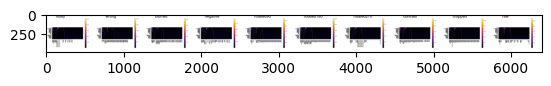

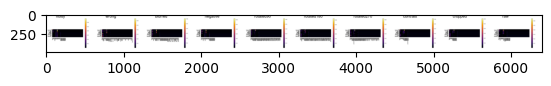

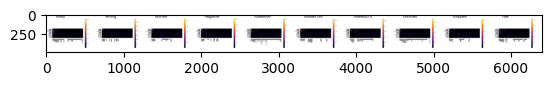

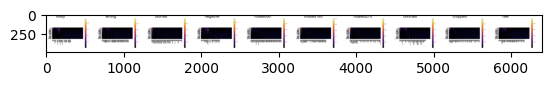

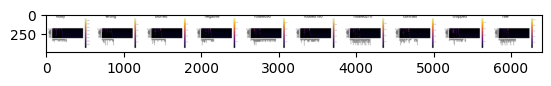

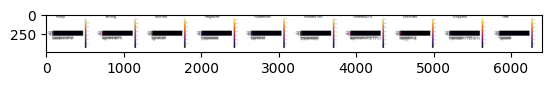

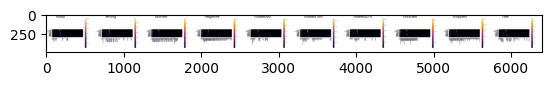

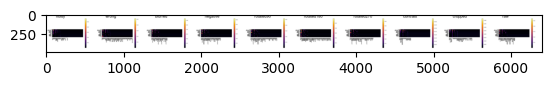

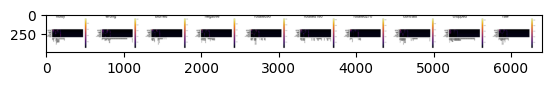

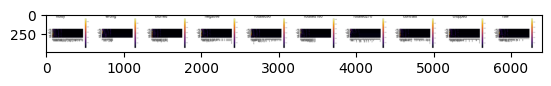

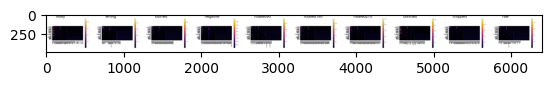

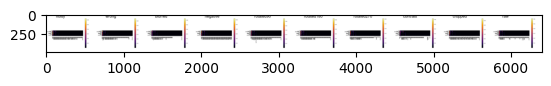

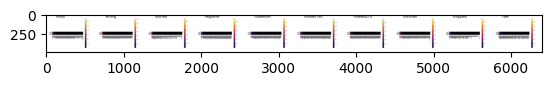

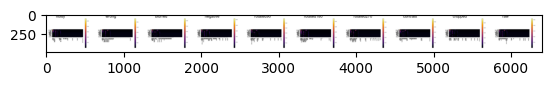

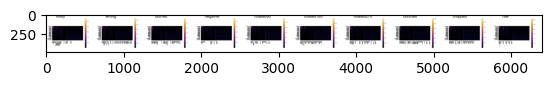

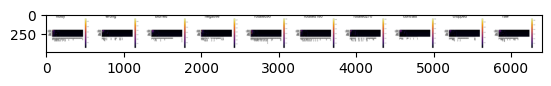

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
transformations = ['noisy','wrong','blurred','negative','rotated90','rotated180','rotated270','contrast','cropped','raw']
dico= {}
photos = []
from PIL import Image

def open_image(path):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image

def save_image(image,path):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = Image.fromarray(image)
    image.save(path)
    return image
for nom in os.listdir('Graphs attention/Attention texte'):
    for transformation in transformations :
        if transformation in nom :
            dico[nom] = {}
            photo = nom.replace(transformation+"_",'').replace(".jpgattention_text.png","")
            trans = transformation
            dico[nom]["transformation"] = trans
            dico[nom]["photo"] = photo
            if photo not in photos :
                photos.append(photo)

for photo in photos :
    n_transformations = len(transformations)
    image_matrix = np.zeros((n_transformations, 1,480,640, 4), dtype=np.uint8)
    for d in list(dico.values()):
        if d["photo"] == photo :
            image= Image.open("Graphs attention/Attention texte/"+d['transformation']+"_"+d['photo']+".jpgattention_text.png")
            image_matrix[transformations.index(d['transformation']), 0] = image
    fig, ax = plt.subplots()
    image_matrix = np.concatenate(np.concatenate(image_matrix, axis=2), axis=0)
    image_matrix = Image.fromarray(np.uint8(image_matrix))
    draw = ImageDraw.Draw(image_matrix)
    font = ImageFont.truetype("ARIAL.TTF", 50)
    for i in range(len(transformations)):
        draw.text(((i+1/5)*640, 0), transformations[i], font=font, fill=(0, 0, 0))
    


    ax.imshow(image_matrix)

    image_matrix = transforms.ToTensor()(image_matrix)

    save_image(image_matrix,"Graphs attention/Attention texte/TEXT"+photo+".png")


In [5]:
import pandas as pd
for noms in ('FalseTrue_eval.csv','TrueTrue_eval.csv'):
    
    for i in range(45):
        df = pd.read_csv(str(i)+noms)
        df['epoch']=i
        if i == 0 :
            data = df
        else :
            data= pd.concat((data,df))
    data.to_csv("tordjx/"+noms)

In [27]:
with open('Images ummt/captions.txt','r') as file : 
    lines = file.readlines()
    file.close()
folder =["blurred","contrast","cropped","negative","noisy","raw","rotated90","rotated180","rotated270","wrong"]

lines = [line[:-1].split(',') for line in  lines]
images= [line[0] for line in lines]
import shutil
with open("Images ummt/all/index.txt","w") as file :
    for name in folder :
        for image in images: 
            file.write(name+"_"+ image+"\n")
            old_path = "Images ummt/"+name+"/"+image
            new_path = "Images ummt/all/"+name+"_"+image
            print(old_path, new_path)
            shutil.copy(old_path, new_path)
    file.close()

Images ummt/blurred/1018148011.jpg Images ummt/all/blurred_1018148011.jpg
Images ummt/blurred/1029450589.jpg Images ummt/all/blurred_1029450589.jpg
Images ummt/blurred/1029737941.jpg Images ummt/all/blurred_1029737941.jpg
Images ummt/blurred/103205630.jpg Images ummt/all/blurred_103205630.jpg
Images ummt/blurred/10350842.jpg Images ummt/all/blurred_10350842.jpg
Images ummt/blurred/1054620089.jpg Images ummt/all/blurred_1054620089.jpg
Images ummt/blurred/1056873310.jpg Images ummt/all/blurred_1056873310.jpg
Images ummt/blurred/1072439304.jpg Images ummt/all/blurred_1072439304.jpg
Images ummt/blurred/1073444492.jpg Images ummt/all/blurred_1073444492.jpg
Images ummt/blurred/1092437557.jpg Images ummt/all/blurred_1092437557.jpg
Images ummt/blurred/109671650.jpg Images ummt/all/blurred_109671650.jpg
Images ummt/blurred/109738763.jpg Images ummt/all/blurred_109738763.jpg
Images ummt/blurred/109982467.jpg Images ummt/all/blurred_109982467.jpg
Images ummt/blurred/110269384.jpg Images ummt/all/

In [ ]:
def moving_average(a, n=1,tail = 0) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    
    return (ret[n - 1:] / n)[tail:]

plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
print(len(model_fr.loss_list)/(29000/batch_size))


In [13]:
from torchvision import models, transforms
from PIL import Image

import os
def open_image(path):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image
def image_noiser(image):
    image = image.to(device) + torch.randn(image.shape).to(device)*0.1
    return image
def save_image(image,path):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = Image.fromarray(image)
    image.save(path)
    return image
def get_all_images_from_folder(path):
    images = []
    folder = [filename for filename  in os.listdir(path) if filename not in ['.amlignore', '.amlignore.amltmp']]
       
    for filename in folder:
        images.append(filename)

    return images
#Noisy
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(image_noiser(open_image("Images ummt/raw/"+images)),"Images ummt/noisy/"+images)
#Wrong
folder = get_all_images_from_folder("Images ummt/raw/")
for i in range(len(folder)):
    save_image(open_image("Images ummt/raw/"+folder[i]),"Images ummt/wrong/"+folder[(i+1)%len(folder)])
#Blur
!pip install opencv-python
import cv2
def blur_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = cv2.blur(image,(5,5))
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(blur_image(open_image("Images ummt/raw/"+images)),"Images ummt/blurred/"+images)
#Negative
def negative_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = 255-image
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):   
    save_image(negative_image(open_image("Images ummt/raw/"+images)),"Images ummt/negative/"+images)
#Rotation
def rotate_image_90(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(rotate_image_90(open_image("Images ummt/raw/"+images)),"Images ummt/rotated90/"+images)
def rotate_image_180(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = cv2.rotate(image,cv2.ROTATE_180)
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(rotate_image_180(open_image("Images ummt/raw/"+images)),"Images ummt/rotated180/"+images)
def rotate_image_270(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = cv2.rotate(image,cv2.ROTATE_90_COUNTERCLOCKWISE)
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(rotate_image_270(open_image("Images ummt/raw/"+images)),"Images ummt/rotated270/"+images)
#Contrast
def contrast_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    # image = cv2.equalizeHist(image)
    image= cv2.convertScaleAbs(image, 10, 2)

    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(contrast_image(open_image("Images ummt/raw/"+images)),"Images ummt/contrast/"+images)
